<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/ML-models/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
!pip install tensorflow

In [163]:
# Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

# Define dataset paths
base_dir = "/content/drive/MyDrive/Dataset4"  # Path to Dataset4 in Google Drive
train_dir = os.path.join(base_dir, "Training")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Testing")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [164]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Image preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=20, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Create a generator with balanced classes
train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary', shuffle=True)
val_generator = val_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')
test_generator = test_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary')


Found 64 images belonging to 2 classes.
Found 17 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [165]:
# Check class distribution in the training data
def check_class_distribution(data_dir):
    """Checks the number of images in each class directory."""
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            print(f"Class '{class_name}': {num_images} images")

print("Training data distribution:")
check_class_distribution(train_dir)
print("\nValidation data distribution:")
check_class_distribution(val_dir)
print("\nTest data distribution:")
check_class_distribution(test_dir)

Training data distribution:
Class 'Real': 33 images
Class 'Fake': 31 images

Validation data distribution:
Class 'Fake': 8 images
Class 'Real': 9 images

Test data distribution:
Class 'Real': 4 images
Class 'Fake': 4 images


In [166]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = True
fine_tune_at = -10
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Build new classification layers on top
efficientnet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification (Fake vs. Real)
])

# Compile model
efficientnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train model
EPOCHS = 10
history = efficientnet_model.fit(train_generator, validation_data=test_generator, epochs=EPOCHS)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 17s/step - accuracy: 0.5208 - loss: 0.6897 - val_accuracy: 0.5156 - val_loss: 0.7079
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 12s/step - accuracy: 0.4375 - loss: 0.8716 - val_accuracy: 0.5156 - val_loss: 0.7161
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 13s/step - accuracy: 0.5521 - loss: 0.7433 - val_accuracy: 0.5156 - val_loss: 0.7224
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.4375 - loss: 0.7605 - val_accuracy: 0.5156 - val_loss: 0.7318
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 9s/step - accuracy: 0.5104 - loss: 0.7397 - val_accuracy: 0.5156 - val_loss: 0.7532
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 9s/step - accuracy: 0.4271 - loss: 0.8139 - val_accuracy: 0.5156 - val_loss: 0.7695
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 9s/step - accuracy: 0.5104 - loss: 0.7048 - val_accuracy: 0.5156 - val_loss: 0.7772
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 13s/step - accuracy: 0.4375 - loss: 0.7353 - val_accuracy: 0.5156 - val_loss: 0.7881
Epoc

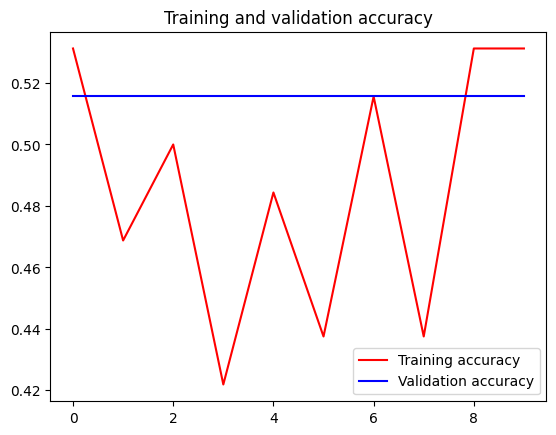

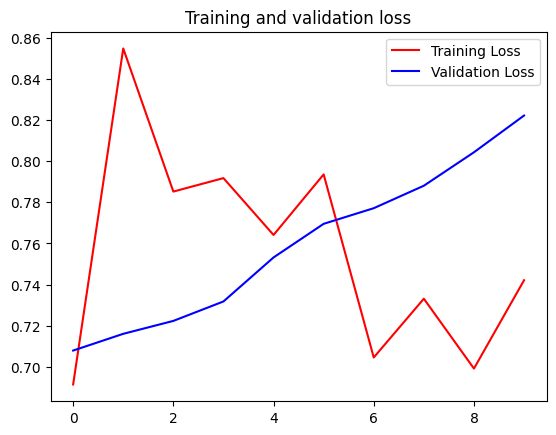

In [167]:
# Plot training history
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [168]:
test_loss, test_acc = efficientnet_model.evaluate(test_generator) # Using the newly created test generator.
print(f"Test Accuracy: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.5208 - loss: 0.8169
Test Accuracy: 51.56%


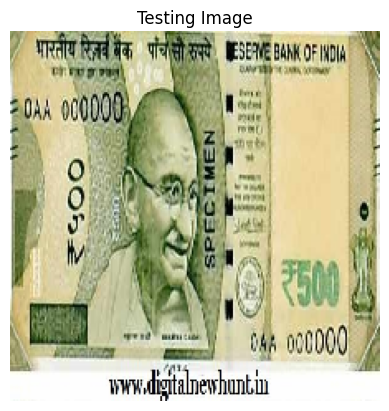

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Real (Confidence: 74.95%)


In [169]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the image path
img_path = "/content/drive/MyDrive/Dataset4/Testing/Fake/fake4.jpg"  # Ensure the path is correct

# Load the image
img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size

# Convert image to array and normalize
img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Show the image
plt.imshow(img)
plt.axis("off")
plt.title("Testing Image")
plt.show()

# Make prediction using efficientnet_model
prediction = efficientnet_model.predict(img_array) # We are now correctly referencing the model

# Interpret the result
class_labels = {0: "Fake", 1: "Real"}  # Ensure class mapping matches train_generator.class_indices
predicted_class = "Real" if prediction[0][0] > 0.5 else "Fake"

# Print the result
print(f"Predicted Class: {predicted_class} (Confidence: {prediction[0][0] * 100:.2f}%)")

In [170]:
efficientnet_model.save("/content/drive/My Drive/efficientnet_fake_currency_model.h5")


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Accuracy: 0.5156
Precision: 0.5156
Recall: 1.0000
F1-score: 0.6804

Classification Report:
              precision    recall  f1-score   support

        Fake       0.00      0.00      0.00        31
        Real       0.52      1.00      0.68        33

    accuracy                           0.52        64
   macro avg       0.26      0.50      0.34        64
weighted avg       0.27      0.52      0.35        64


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


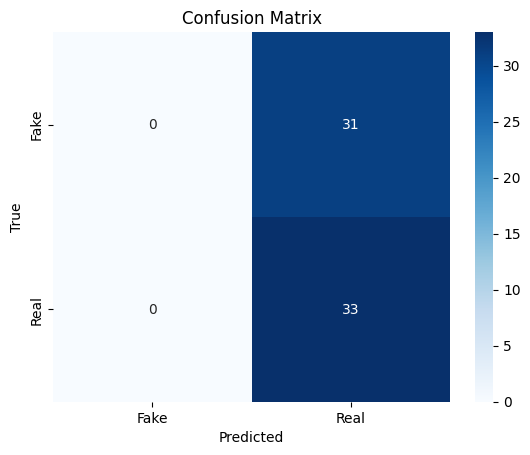

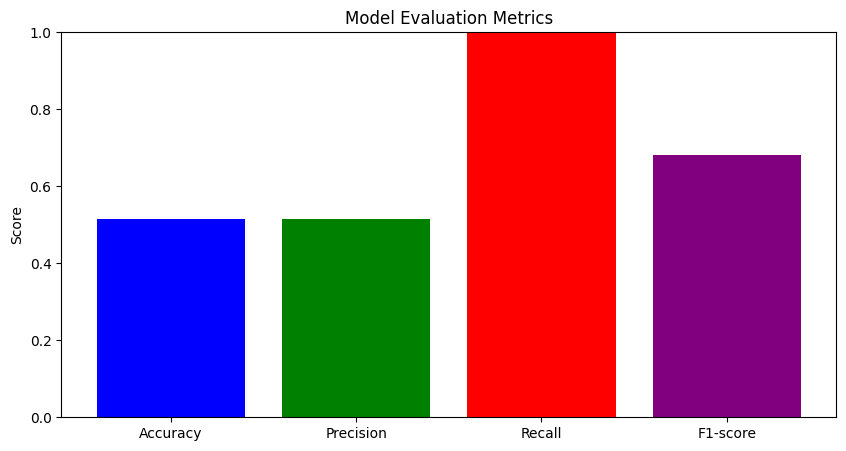

In [171]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and class labels
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generate predictions on the test data
predictions = efficientnet_model.predict(test_generator)

# Convert probabilities to binary predictions (0 or 1)
binary_predictions = (predictions > 0.5).astype(int).flatten()

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, binary_predictions, target_names=class_labels))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(true_labels, binary_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 5))
plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim([0, 1]) # Set y-axis limits to 0-1
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.show()